В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
# --------------------------------------------------------
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
# --------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
%matplotlib inline

In [ ]:
def plot_ROC_AUC(clf, X, y):
  """ 
  Рисует кривую ROC. 

  args:

  clf --- классификатор;
  X --- тестовая выборка;
  y --- ответы на тестовой выборке;

  """
  pred_proba = clf.predict_proba(X)
  pred_proba = pred_proba[:, 1]

  fpr, tpr, _ = roc_curve(y, pred_proba)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 8))

  plt.plot(fpr, tpr, color='darkorange',
          label='ROC кривая (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right");
  plt.grid()

In [ ]:
X = pd.read_csv('https://raw.githubusercontent.com/d3vyatk4ru/DZ2ML/main/weather.csv', na_values=np.nan)

### Предобработка данных

In [ ]:
# заменяем 'No' на 0, 'Yes' на 1 
X.RainToday = X.RainToday.replace({'No': 0, 'Yes': 1})
X.RainTomorrow = X.RainTomorrow.replace({'No':0, 'Yes': 1})

# удаляем строки, где в столбце RainToday есть NaN
X = X.dropna(axis='index', how='any', subset=["RainToday"])

# приводим дату к типу даты
X["Date"] = pd.DatetimeIndex(X["Date"])

In [ ]:
# записываем метки в отдельный массив
y = X.RainTomorrow
y = y.values

# удаляем столбец с метками и стобец с номерами записей
del X['RainTomorrow']
del X["Unnamed: 0"]

In [ ]:
# приводим следующие 4 столбца к строковому типу, чтобы использовать LabelEncoder
X["WindGustDir"] = X["WindGustDir"].astype(str)
X["WindDir9am"] = X["WindDir9am"].astype(str)
X["WindDir3pm"] = X["WindDir3pm"].astype(str)
X["Location"] = X["Location"].astype(str)

In [ ]:
# приводим к LabelEncoder
le = preprocessing.LabelEncoder()
X["WindGustDir"] = le.fit_transform(X["WindGustDir"])
X["WindDir9am"] = le.fit_transform(X["WindDir9am"])
X["WindDir3pm"] = le.fit_transform(X["WindDir3pm"])
X["Location"] = le.fit_transform(X["Location"])

In [ ]:
# Здесь была попытка заменять пропущенные значения учитвая город и месяц, 
# но это не дало значительных приростов в точности


# columns = list(X.columns)
# columns.remove("Date"), columns.remove("Location")
# for name in columns:
#   for month in X["Date"].dt.month.unique():
#     for city in X["Location"].unique():
#       cond = (X["Date"].dt.month == month) & (X["Location"] == city)
#       X[name][cond] = X[name][cond].fillna(X[name][cond].median() if not np.isnan(X[name][cond].mean()) else 0.0)

In [ ]:
columns = list(X.columns)
columns.remove("Date"), columns.remove("Location")
for name in columns:
  for month in X["Date"].dt.month.unique():
    cond = (X["Date"].dt.month == month)
    X[name][cond] = X[name][cond].fillna(X[name][cond].mean() if not np.isnan(X[name][cond].mean()) else 0.0)

In [ ]:
# в столбец с датой записываем только месяц
X["Date"] = X["Date"].dt.month

In [ ]:
# DataFrame X будет использовать для kNN, так в нем проклятие размерности 
# будет проявлять себя еще более сильно. 
X_la = X[:]

In [ ]:
# переводим следующие столбцы в OHE
for column in ("Location", "WindGustDir", "WindDir9am", "WindDir3pm", "Date"):
  X = pd.concat([X, pd.get_dummies(X[column], prefix=column)], axis=1)
  del X[column]

In [ ]:
X_values = X.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_values, y, test_size=0.25, random_state=42, shuffle = False)

scaler = preprocessing.StandardScaler()
scaler.fit(X_train, y_train)

# масштабирование теста и трэйна
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Логистическая регрессия

In [ ]:
logReg = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.9)

# подбор с помощью сетки
params = {
          "C" : range(0, 1000, 100),
}

grid = GridSearchCV(logReg, params, cv=5)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=0.9,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='elasticnet',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': range(0, 1000, 100)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [ ]:
grid.best_params_

{'C': 100}

In [ ]:
logReg = LogisticRegression(random_state=42,
                            penalty='elasticnet',
                            solver='saga',
                            l1_ratio=0.9,
                            max_iter=300,
                            C=100
                            )

In [ ]:
logReg.fit(X_train_scaled, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.9, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(f'\nScore of model is {logReg.score(X_test_scaled, y_test)}')


Score of model is 0.8532545387390971


In [ ]:
y_pred = logReg.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=['Rain', 'No rain']))

              precision    recall  f1-score   support

        Rain       0.87      0.96      0.91     27684
     No rain       0.75      0.47      0.58      7513

    accuracy                           0.85     35197
   macro avg       0.81      0.71      0.75     35197
weighted avg       0.84      0.85      0.84     35197



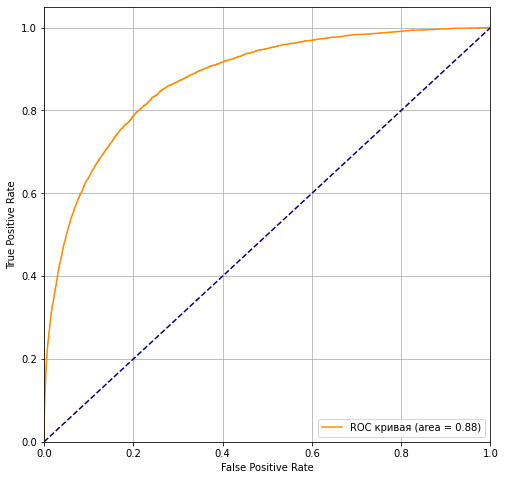

In [ ]:
plot_ROC_AUC(logReg, X_test_scaled, y_test)

### Метод ближайших соседей

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
X_la_values = X_la.values

X_train, X_test, y_train, y_test = train_test_split(X_la_values, y, test_size=0.25, random_state=42)

scaler = preprocessing.StandardScaler()
scaler.fit(X_train, y_train)

# масштабирование теста и трэйна
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# подбор кол-ва соседей без сетки 
for n_neighbors in range(7, 15, 2):
  nbrs = KNeighborsClassifier(n_neighbors)
  nbrs.fit(X_train_scaled, y_train)
  print(f"The acc for {n_neighbors} is equal {nbrs.score(X_test_scaled, y_test)}\n")

The acc for 7 is equal 0.8395886013012472

The acc for 9 is equal 0.8402420660851777

The acc for 11 is equal 0.8415774071653834

The acc for 13 is equal 0.8430548058073131



In [ ]:
nbrs = KNeighborsClassifier(n_neighbors=15, p=2)
nbrs.fit(X_train_scaled, y_train)
score_knn = nbrs.score(X_test_scaled, y_test)
print(f"The acc is equal {score_knn}\n")

The acc is equal 0.8435946245418644



In [ ]:
y_pred = nbrs.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=['Rain', 'No rain']))

              precision    recall  f1-score   support

        Rain       0.86      0.95      0.90     27387
     No rain       0.74      0.46      0.57      7810

    accuracy                           0.84     35197
   macro avg       0.80      0.71      0.74     35197
weighted avg       0.83      0.84      0.83     35197



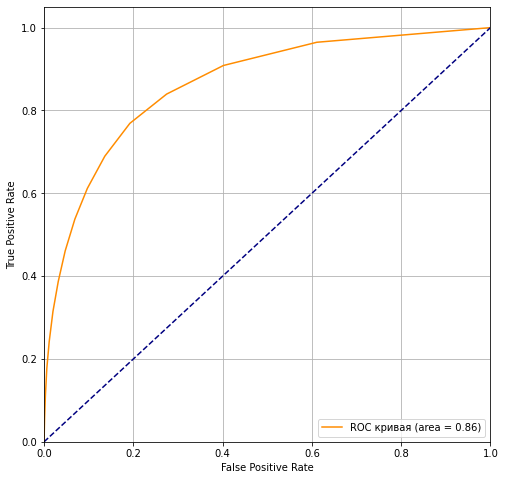

In [ ]:
plot_ROC_AUC(nbrs, X_test_scaled, y_test)

### Наивный Байес

In [ ]:
prob = 0.9

naiveBayes = GaussianNB(priors=[prob, 1 - prob])
naiveBayes.fit(X_train_scaled, y_train)
naiveBayes.score(X_test_scaled, y_test)

# print(classification_report(y_test, naiveBayes.predict(y_test.reshape(-1, 1)), target_names=['Rain', 'No rain']))

0.816802568400716

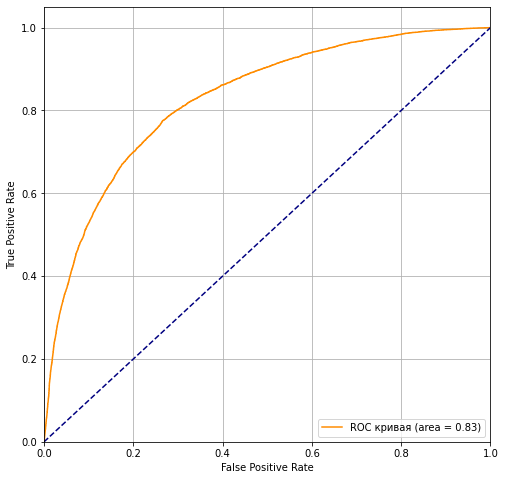

In [ ]:
plot_ROC_AUC(naiveBayes, X_test_scaled, y_test)

### Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [ ]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

In [ ]:
def probability(theta, X):
    result = 1 / ( 1 + np.exp(-np.dot(X, theta)))
    return result

prob = probability(theta, X)

assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [ ]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    result = np.asarray(prob)
    result[np.where(prob > threshold)] = 1
    result[np.where(prob <= threshold)] = 0
    return result

y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left( 1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta} $$

Реализуем его в функции logloss:

In [ ]:
def logloss(theta, X, y): 

    y[np.where(y == 0)] = -1
    result = np.log(1 + np.exp(-y * np.dot(X, theta))).sum() / X.shape[0]
    
    return result

In [ ]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

Реализуйте рассчет градиента в матричном виде:

In [ ]:
def gradient(theta, X, y):

    y[np.where(y == 0)] = -1
    result = X.T.dot(1 / (1 + np.exp(-y * X.dot(theta))) * np.exp(-y * X.dot(theta)) * (-y))

    return result / X.shape[0] 


assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [ ]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

In [ ]:
X, y = make_classification(n_samples=2000)

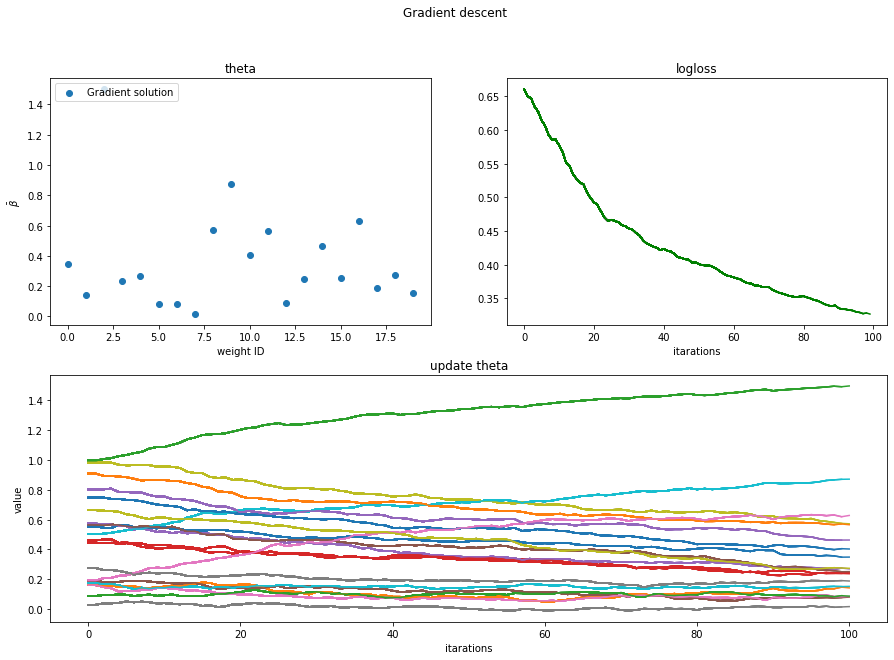

In [ ]:
optimal_theta = fit(X, y)

### Своя логистическая регрессия для погоды

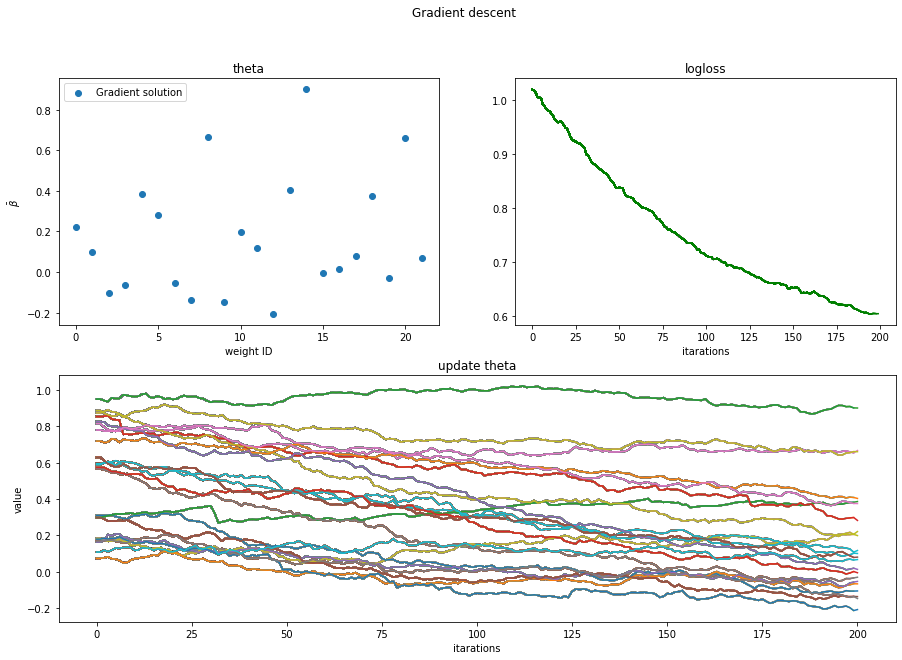

In [ ]:
optimal_theta = fit(X_train_scaled, y_train, iters=200)

In [ ]:
y_pred = binary_class_prediction(optimal_theta, X_test_scaled, threshold=0.83)

In [ ]:
print(f"The acc is equal {(y_pred == y_test).sum() / len(y_pred)}")

The acc is equal 0.8271159473818791


In [ ]:
print(classification_report(y_test, y_pred, target_names=['Rain', 'No rain']))

              precision    recall  f1-score   support

        Rain       0.85      0.95      0.89     27387
     No rain       0.68      0.41      0.51      7810

    accuracy                           0.83     35197
   macro avg       0.77      0.68      0.70     35197
weighted avg       0.81      0.83      0.81     35197



# Выводы

Лучшие результаты по качеству и времени выполнения показала логистическая регрессия.
Метрики можно увидеть в ячейке выполнения.
Параметры при которых были достигнуты эту результаты:
C = 100, intercept_scaling = 1, l1_ratio = 0.9, 
max_iter = 300, penalty = 'elasticnet', solver = 'saga', tol = 0.0001

Метод прижайшего соседа дает результаты сравнимые с лог. ререссией, однако этот метод более
"тяжеловестный", так как является непараметрическим и просто запоминает обучающую выборку и 
при классификации новой выборки (в нашем случае тестовой) выполняется очень долго. Так же
этот метод сильнее всего подвержен проклятию рамерности, так как чем больше и разреженнее
признаковое пространство, тем дольше выполняются вычисления. Параметры следующие:
n_neighbors = 15, weights = 'uniform', metric = 'minkowski', p = 2

Наивный Байес на нормальном распредлении показал худший результат по качеству.

Собственная реализация логистической регрессии, показала результат хуже, чем библиотечная реализация, если рассматривать порог равный 0.5, в силу того, что шаг градиента постоянный, не было ни одной регуляриции. Если варьировать порог для конкретной задачи и подобрать его, то качество сравнимо с библиотечными функйиями. Время обучения тоже дольше, так это было реализовано с помощью медленногоя ызка Python. (Numpy, конечно, на С, но там есть цикл в обучении и он долгий)